[View in Colaboratory](https://colab.research.google.com/github/NicknameSoHard/Open_course_ML/blob/master/ML_homework_5.ipynb)

**Это решение вышло совсем другим, а не как в примере, но выводы все совпали. Хотелось бы точнее посмотреть на ошибки.**

**Задание 1.** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?

*   70.00%
*   83.20% 
*   **83.70% **
*   87.50% 


![alt text](https://pp.userapi.com/c824202/v824202942/191b5e/rg2WR7TDlqw.jpg)

In [1]:
from math import factorial

def Combination_func(n, k):
  return factorial(n) / ( factorial(k) * factorial( n - k ) )

N = 5
p = 0.7
m = int(N/2) + 1
result = 0

for i in range(m, N+1):
  result += Combination_func(N, i) * p**i * (1-p)**(N-i)
  
print(result)

0.8369199999999999


In [2]:
!wget https://raw.githubusercontent.com/Yorko/mlcourse_open/master/data/credit_scoring_sample.csv -P drive/Open_course_ML  

--2018-07-29 15:06:24--  https://raw.githubusercontent.com/Yorko/mlcourse_open/master/data/credit_scoring_sample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1812928 (1.7M) [text/plain]
Saving to: ‘drive/Open_course_ML/credit_scoring_sample.csv’

credit_scoring_samp 100%[===================>]   1.73M  11.1MB/s    in 0.2s    

2018-07-29 15:06:25 (11.1 MB/s) - ‘drive/Open_course_ML/credit_scoring_sample.csv’ saved [1812928/1812928]



In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

## Считываем данные
data = pd.read_csv('drive/Open_course_ML/credit_scoring_sample.csv', sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

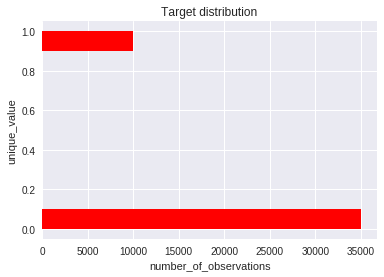

In [4]:
## Посмотрим на распределение классов в зависимой переменной

ax =data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [0]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']

## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   
  
table = delete_nan(data)

## Разделяем таргет и признаки 
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

# Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте np.random.seed(0), как это сделано в статье.

In [6]:
def get_random_intervals(data_values, numbers_of_sets ):
  size = (numbers_of_sets, len(data_values))
  random_indexes = np.random.randint(0, len(data_values), size=size ) 
  return data_values[ random_indexes ]

def count_percentile( data_values, q ):
  return np.percentile(data_values, [100 * q / 2., 100 * (1 - q / 2.)])


np.random.seed(0)

values_age_not_paid = table[ table['SeriousDlqin2yrs'] == 1 ]['age'].values

scores_age_not_paid = [ np.mean(percentile) 
                            for percentile in get_random_intervals( values_age_not_paid, 1000 ) ]

print("Age that not paid: mean intervals",  count_percentile( scores_age_not_paid, 0.1 ) )

Age that not paid: mean intervals [45.71379414 46.12700479]


## Подбор параметров для модели логистической регрессии

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0 до 1. Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая
## не будет переобучена, с одной стороны, и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [8]:
best_roc_logreg = GridSearchCV(lr, parameters,  n_jobs=-1, scoring='roc_auc', cv=skf )
best_roc_logreg.fit(X,y)
best_roc_logreg.best_params_

{'C': 0.001}

**Задание 4.** 
 Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [9]:
best_roc_logreg.cv_results_['std_test_score']

array([0.00531169, 0.00635747, 0.008183  , 0.00826878, 0.00832309,
       0.00832973])

In [10]:
from sklearn.metrics import accuracy_score

logreg_accuracy = best_roc_logreg.best_score_
logreg_accuracy

0.795409411236062

## Определение влияния признаков

**Задание 5.**
Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [11]:
lr = LogisticRegression(random_state=5, class_weight= 'balanced', C = 0.001)
lr.fit(X,y)

value_coefficient = lr.coef_ 

attribute = dict()
i = 0
for name in X.columns.values:
  attribute.update( {name : np.linalg.norm(value_coefficient[0][i]) })
  i+=1

sorted_dict_keys = sorted( attribute, key = attribute.get )[::-1]
for key in sorted_dict_keys:
  print(key, attribute[key])

NumberOfTime30-59DaysPastDueNotWorse 0.48234922954301296
NumberOfTimes90DaysLate 0.4303141594500768
NumberOfDependents 0.11535624357879255
NumberOfTime60-89DaysPastDueNotWorse 0.06595786075660731
age 0.018185281632325617
MonthlyIncome 1.1447658180792683e-05
DebtRatio 1.0798311574956725e-05


Наиболее важен: **NumberOfTime30-59DaysPastDueNotWorse**

**Задание  6.** Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией [softmax](https://en.wikipedia.org/wiki/Softmax_function))

In [12]:
def cout_softmax_attribute(x):
  exp = np.exp(x)
  return exp / np.sum( exp )

softmax_attribute = cout_softmax_attribute( list( attribute.values() ) )

i=0
for keys in list(attribute.keys()):
  print(keys,softmax_attribute[i])
  i+=1

age 0.1217185647583706
NumberOfTime30-59DaysPastDueNotWorse 0.19361574161507142
DebtRatio 0.11952637404202986
NumberOfTimes90DaysLate 0.1837985666445384
NumberOfTime60-89DaysPastDueNotWorse 0.12767450720252946
MonthlyIncome 0.11952645165610033
NumberOfDependents 0.13413979408135984


**Задание 7.** 
Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf))

In [13]:
np.exp(value_coefficient[0][0]*20)

0.6950957781347274

# Случайный лес

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7, 9], 
              'max_depth': [5,10,15]}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf

**Задание  8.**  На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [0]:
best_param_rf = GridSearchCV(rf, parameters, n_jobs=-1, 
                              scoring ='roc_auc', cv=skf)
best_param_rf.fit(X,y)

random_forest_accuracy = best_param_rf.best_score_

In [22]:
(random_forest_accuracy - logreg_accuracy)*100

4.0

**Задание  9.** Определите какой признак имеет самое слабое влияние.

In [17]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced',
                           max_depth=10, max_features=2, min_samples_leaf=9)
rf.fit(X,y)
importances = rf.feature_importances_

attribute = dict()
i=0
for name in X.columns.values:
  attribute.update( {name : np.linalg.norm(importances[i]) })
  i+=1
  
sorted_dict_keys = sorted( attribute, key = attribute.get )[::-1]
for key in sorted_dict_keys:
  print(key, attribute[key])

NumberOfTime30-59DaysPastDueNotWorse 0.30141858488389767
NumberOfTimes90DaysLate 0.2788621774423781
NumberOfTime60-89DaysPastDueNotWorse 0.1535859420107645
age 0.11695037256668306
DebtRatio 0.07618970465193636
MonthlyIncome 0.05853628648030928
NumberOfDependents 0.014456931964030908


Самое слабое влияние у **NumberOfDependents** 

** Задание  10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

* меньше тратится времени для тренировки модели; item
* меньше параметров для перебора;
* **интепретируемость признаков;**
* линейные свойства алгоритма.

# Бэггинг

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

**Задание 11.**  Следующая задача обучить бэггинг классификатор (random_state=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не GridSearchCV, а RandomizedSearchCV. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для RandomizedSearchCV. Также не забудьте передать параметр валидации cv и random_state=1. Какая лучшая точность получилась?

In [0]:
bagging = BaggingClassifier( LogisticRegression(class_weight='balanced'),
                             n_estimators=100, n_jobs=-1, random_state=42 )

best_bagging_parameters = RandomizedSearchCV(bagging, parameters, n_iter=20,  
                                             scoring='roc_auc', cv=skf,
                                             random_state=1, n_jobs=-1 )
best_bagging_parameters.fit(X,y)

In [20]:
best_bagging_parameters.best_score_

0.8076172570918905

**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

* для бэггинга важно использовать как можно меньше признаков
* бэггинг лучше работает на небольших выборках
* **меньше корреляция между одиночными моделями**
* чем больше признаков, тем меньше теряется информации

![alt text](https://pp.userapi.com/c849032/v849032378/39d49/4wPjIREuMqg.jpg)